<a href="https://www.kaggle.com/code/beatafaron/ifrs-9-credit-risk-staging-ecl-with-mpv-4?scriptVersionId=268734902" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction

**IFRS 9 – International Financial Reporting Standard 9** sets out how financial institutions must recognize and measure credit losses on loans and other financial assets. A key feature of IFRS 9 is **staging**, which classifies exposures into:

* **Stage 1** – performing assets (12-month ECL)
* **Stage 2** – underperforming assets with significant credit risk increase (lifetime ECL)
* **Stage 3** – credit-impaired assets (lifetime ECL, credit-impaired)

This notebook demonstrates a **simplified IFRS 9 framework**:

* Building a staging model
* Calculating **Expected Credit Loss (ECL)** based on **PD × LGD × EAD**
* Comparing results across models and stages
* Summarizing portfolio KPIs and stress-testing opportunities

The focus is on a **minimum viable product (MVP)** version of IFRS 9, which can later be extended to more advanced approaches such as survival analysis, Markov chain migrations, and macro-driven scenario modeling.


# 2. Load Data & Models
>Business note

>In practice, banks maintain a portfolio table with exposures, customer info, and risk flags.
>We enrich this table with model outputs (PDs). Multiple models can be run, but one must be declared the champion model for official PD calculations. Challenger models are used for benchmarking and monitoring.

In [1]:
from datetime import date, datetime
import pandas as pd
import joblib
import numpy as np
from utils import plot_hist_with_trend, save_and_display
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import (
#    confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,
#    classification_report, RocCurveDisplay)
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
df_all = pd.read_csv("/kaggle/input/loan-credit-risk-and-population-stability/loan_2014_18.csv", usecols = ['id', 'loan_amnt', 'out_prncp', 'total_rec_prncp', 'recoveries', 'loan_status' ])
df=pd.read_csv("/kaggle/input/loan-credit-risk-and-population-stability/df_2014-18_selected.csv")
df.head()

,total_rec_late_fee,recoveries,last_pymnt_amnt,loan_amnt_div_instlmnt,debt_settlement_flag,loan_age,total_rec_int,out_prncp,time_since_last_credit_pull,time_since_last_payment,int_rate%,total_rec_prncp,loan_status_binary
0,0.0,0.0,2591.95,31.925082,0.0,2707.0,1500.44,0.00,1734.0,1734.0,7.97,12000.00,1
1,0.0,0.0,0.00,30.111696,0.0,2707.0,5997.56,6158.89,1734.0,1734.0,11.99,25841.11,1
2,0.0,0.0,952.65,41.988138,0.0,2707.0,12794.81,22376.90,1734.0,1734.0,15.05,17623.10,1
3,0.0,0.0,0.00,31.925295,0.0,2707.0,1983.00,2455.43,1734.0,1734.0,7.97,13544.57,1
4,0.0,0.0,0.00,32.285837,0.0,2707.0,3490.01,9873.08,1734.0,1764.0,7.21,23126.92,0


In [3]:
# force the same align
df=df[['out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'int_rate%', 'loan_age',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_amnt_div_instlmnt']]

In [4]:
scaler = joblib.load("/kaggle/input/loan-credit-risk-and-population-stability/scaler.pkl")
X_raw = df  
X_scaled = scaler.transform(X_raw)

# 3. PD from LR, RF, NN

In [5]:
path_base = "/kaggle/input/loan-credit-risk-and-population-stability/"

lr_model = joblib.load(path_base + "lr_model.pkl")
rf_model = joblib.load(path_base + "rf_soft_model.pkl")
nn_model = joblib.load(path_base + "nn_soft_model.pkl")

print("Models loaded.")

Models loaded.


In [6]:
df['pd_lr'] = lr_model.predict_proba(X_scaled)[:,0]
df['pd_nn'] = nn_model.predict_proba(X_scaled)[:,0]
df['pd_rf'] = rf_model.predict_proba(X_scaled)[:,0]
df[['pd_lr','pd_rf','pd_nn']].head(10)

,pd_lr,pd_rf,pd_nn
0,0.000545,0.00,4.920934e-07
1,0.000517,0.00,4.595808e-09
2,0.000670,0.01,6.029399e-12
3,0.004687,0.02,1.382094e-09
4,0.000066,0.01,5.336233e-07
5,0.022663,0.01,3.654175e-08
6,0.000001,0.00,2.138783e-04
7,0.001180,0.00,3.367435e-03
8,0.000125,0.00,2.410049e-05
9,0.018931,0.00,8.155585e-10


In [7]:
# LR
fig = plot_hist_with_trend(
    df, 'pd_lr',
    bins=50,
    title="Distribution of predicted 12M PD (champion model - LR)",
    height=560, range_x=(0.0, 1.0), show_trend=True, smooth_window=7
)

In [30]:
save_and_display(fig, "pd_lr_distribution")

'images/pd_lr_distribution.html'

In [31]:
# RF
fig = plot_hist_with_trend(
    df, 'pd_rf',
    bins=50,
    title="Distribution of predicted 12M PD (challenger model - RF)",
    height=560,
    range_x=(0.0, 1.0),   # możesz zawęzić np. do (0.0, 0.2) dla zoomu na „początek”
    show_trend=True,
    smooth_window=7,
    density=False
)
save_and_display(fig, "pd_rf_distribution")

'images/pd_rf_distribution.html'

In [33]:
# NN
fig = plot_hist_with_trend(
    df, 'pd_nn',
    bins=50,
    title="Distribution of predicted 12M PD (challenger model - NN)",
    height=560, range_x=(0.0, 1.0), show_trend=True, smooth_window=7
)
save_and_display(fig, "pd_nn_distribution")

'images/pd_nn_distribution.html'

>Logistic Regression provides interpretable and stable PD estimates, Random Forest captures more complex non-linear patterns, and the Neural Network offers higher flexibility at the cost of explainability. This setup illustrates the trade-off between accuracy and interpretability in credit risk modeling.

In [32]:
df['account_id'] = df_all['id']

In [12]:
SNAPSHOT_DATE = pd.Timestamp(date.today())
RUN_ID = "2025-08-batch1"
SCENARIO = "base"

In [13]:
#  Reshape to long format: (account_id, model, pd_12m)
pd_long = df[['account_id','pd_lr','pd_rf','pd_nn']].melt(
    id_vars='account_id', var_name='model', value_name='pd_12m')
pd_long['model'] = pd_long['model'].str.replace('pd_', '', regex=False)
# Add snapshot date (as if today we ran the scoring batch)
pd_long['snapshot_date'] = SNAPSHOT_DATE
pd_long.head()

,account_id,model,pd_12m,snapshot_date
0,120122535,lr,0.000545,2025-10-17
1,119374887,lr,0.000517,2025-10-17
2,119321612,lr,0.000670,2025-10-17
3,120122034,lr,0.004687,2025-10-17
4,118659541,lr,0.000066,2025-10-17


# 4. EAD

### Risk Base table

In [14]:
cols_needed = [
    'id', 'loan_amnt', 'out_prncp', 'total_rec_prncp', 'recoveries', 'loan_status'
]
avail = [c for c in cols_needed if c in df_all.columns]
risk_base = df_all[avail].copy()

In [15]:
risk_base = risk_base.rename(columns={'id':'account_id'})
risk_base.head()

,account_id,loan_amnt,out_prncp,total_rec_prncp,recoveries,loan_status
0,120122535,12000.0,0.00,12000.00,0.0,Fully Paid
1,119374887,32000.0,6158.89,25841.11,0.0,Current
2,119321612,40000.0,22376.90,17623.10,0.0,Current
3,120122034,16000.0,2455.43,13544.57,0.0,Current
4,118659541,33000.0,9873.08,23126.92,0.0,Late (31-120 days)


In [16]:
# EAD = out_prncp; if NaN, fallback to (loan_amnt - total_rec_prncp), clipped at 0
risk_base['ead'] = risk_base['out_prncp'].fillna(
    (risk_base['loan_amnt'] - risk_base['total_rec_prncp'])
).clip(lower=0)

In [17]:
df_current_EAD = risk_base[['account_id','ead']].copy()
df_current_EAD['snapshot_date'] = SNAPSHOT_DATE

In [18]:
pd_long = pd_long.merge(
    df_current_EAD,
    on=['account_id','snapshot_date'],
    how='left'
)

In [19]:
pd_long.head()

,account_id,model,pd_12m,snapshot_date,ead
0,120122535,lr,0.000545,2025-10-17,0.00
1,119374887,lr,0.000517,2025-10-17,6158.89
2,119321612,lr,0.000670,2025-10-17,22376.90
3,120122034,lr,0.004687,2025-10-17,2455.43
4,118659541,lr,0.000066,2025-10-17,9873.08


>Exposure at Default (EAD) was computed as the outstanding balance at the time of potential default. This represents the credit institution’s total exposure and acts as the base for further Expected Credit Loss (ECL) calculation.

# 5. LGD 

In [20]:
LGD_DEFAULT = 0.60
lgd_df = risk_base[['account_id','recoveries','ead']].copy()
lgd_df['lgd'] = LGD_DEFAULT

# Where we have positive recoveries AND positive EAD, use observed recovery-based LGD
mask = (lgd_df['recoveries'] > 0) & (lgd_df['ead'] > 0)
obs_rec_rate = (lgd_df.loc[mask, 'recoveries'] / lgd_df.loc[mask, 'ead']).clip(0, 0.95)
lgd_df.loc[mask, 'lgd'] = (1 - obs_rec_rate).clip(0.05, 0.95)

# Keep only what we need and add the same snapshot_date
lgd_df = lgd_df[['account_id','lgd']].copy()
lgd_df['snapshot_date'] = SNAPSHOT_DATE

# Attach LGD to pd_long and compute ECL ---
pd_long = pd_long.merge(lgd_df, on=['account_id','snapshot_date'], how='left')
pd_long['lgd'] = pd_long['lgd'].fillna(LGD_DEFAULT)



>Loss Given Default (LGD) represents the percentage of exposure not expected to be recovered after default. For unsecured retail exposures, LGD values typically range between 30–60%. The calculated values in this dataset fall within a realistic range.

# 6. ECL

In [21]:
# ECL = PD * LGD * EAD
pd_long['ecl'] = pd_long['pd_12m'] * pd_long['lgd'] * pd_long['ead']

>Expected Credit Loss was derived using the formula ECL = PD × LGD × EAD. This metric quantifies the potential future loss from the credit portfolio and serves as a regulatory requirement under IFRS 9.

# 7. Staging (MPV)

In [22]:
# ---- 1) Bring loan_status into pd_long ----
status_map = risk_base[['account_id','loan_status']].copy()


pd_long = pd_long.merge(status_map, on='account_id', how='left')

# ---- 2) Map loan_status to a stage suggestion ----
stage3_status = {'Charged Off', 'Default', 'Late (31-120 days)'}   # impaired/default bucket
stage2_status = {'Late (16-30 days)', 'In Grace Period'}           # early delinquency / SICR
stage1_status = {'Current', 'Fully Paid'}

def stage_from_status(s):
    if pd.isna(s):
        return np.nan
    s = str(s)
    if s in stage3_status:
        return 3
    if s in stage2_status:
        return 2
    if s in stage1_status:
        return 1
    return np.nan

pd_long['stage_status'] = pd_long['loan_status'].apply(stage_from_status)

>Accounts were classified into Stage 1, Stage 2, or Stage 3 based on risk characteristics and credit deterioration. This simplified staging framework demonstrates how IFRS 9 requires banks to recognize higher lifetime losses once credit risk significantly increases.

# 8. SICR rule



**SICR** stands for **Significant Increase in Credit Risk**.

It’s a **core IFRS 9 concept**:

* The standard says: loans must move from **Stage 1 → Stage 2** if the bank observes a **significant increase in credit risk since origination**.
* Why? Because Stage 1 only requires **12-month ECL**, while Stage 2 requires **lifetime ECL** (bigger reserve).

---

### How SICR is determined

Banks must define **rules** for when an account has deteriorated enough to trigger Stage 2. Common criteria are:

1. **Days Past Due (DPD) backstop:**

   * If a loan is **≥30 days past due**, it **must** be Stage 2.
   * If it reaches **90 days past due**, it goes Stage 3 (default).

2. **Relative PD increase:**

   * Example: if the current PD has **doubled** compared to PD at origination, or increased by >100 basis points (1%), the account moves to Stage 2.

3. **Credit risk grade migration:**

   * If an internal credit rating drops (e.g., BBB → B), that can trigger SICR.

4. **Qualitative indicators:**

   * Bankruptcy proceedings, forbearance, restructuring, etc.

---

### Why it matters

* Stage allocation directly impacts **reserves** (ECL).
* If SICR is triggered, lifetime PD is used (much higher ECL).
* Regulators watch carefully that banks are **not too lax** (to avoid under-reserving) or **too harsh** (to avoid procyclical over-reserving).

---

In our notebook we mimicked SICR with:

* **loan\_status** mapping (late → Stage 2),
* and a **PD threshold rule** (if 12M PD > 20%, we also force Stage 2).



In [23]:
# ----  Add a PD-based SICR rule (tune threshold) ----
PD_SICR_THRESHOLD = 0.20   # e.g., 20% 12M PD triggers Stage 2
pd_long['stage_pd_rule'] = np.where(pd_long['pd_12m'] > PD_SICR_THRESHOLD, 2, 1)

# ----  Combine rules: take the "worst" (max) stage among status-based and PD-based ----
pd_long['stage'] = pd_long[['stage_status','stage_pd_rule']].max(axis=1)
pd_long['stage'] = pd_long['stage'].fillna(1).astype(int)  # default to Stage 1 if unknown

# ----  PD used for ECL (keep it simple now- MPV) ----
# Stage 1 → use 12m PD; Stage 2 → (placeholder) still 12m PD (later swap to lifetime);
# Stage 3 → PD = 100%
pd_long['pd_used'] = pd_long['pd_12m'].astype(float)
pd_long.loc[pd_long['stage'] == 3, 'pd_used'] = 1.0

# ----  Recompute ECL = PD_used * LGD * EAD ----
pd_long['ead'] = pd_long['ead'].fillna(0.0)
pd_long['lgd'] = pd_long['lgd'].fillna(0.60)
pd_long['ecl'] = pd_long['pd_used'] * pd_long['lgd'] * pd_long['ead']

# ---- 7) Quick portfolio summaries ----
by_model = (pd_long
            .groupby('model', as_index=False)
            .agg(total_ead=('ead','sum'),
                 avg_pd=('pd_used','mean'),
                 avg_lgd=('lgd','mean'),
                 total_ecl=('ecl','sum')))

by_model_stage = (pd_long
                  .groupby(['model','stage'], as_index=False)
                  .agg(total_ead=('ead','sum'),
                       avg_pd=('pd_used','mean'),
                       avg_lgd=('lgd','mean'),
                       total_ecl=('ecl','sum'))
                  .sort_values(['model','stage']))

display(by_model)
display(by_model_stage)

,model,total_ead,avg_pd,avg_lgd,total_ecl
0,lr,3.694334e+09,0.179217,0.6,1.042532e+08
1,nn,3.694334e+09,0.162731,0.6,5.480330e+07
2,rf,3.694334e+09,0.164616,0.6,6.261544e+07


,model,stage,total_ead,avg_pd,avg_lgd,total_ecl
0,lr,1,3.499159e+09,0.016526,0.6,3.573324e+07
1,lr,2,1.042238e+08,0.313140,0.6,1.394906e+07
2,lr,3,9.095153e+07,1.000000,0.6,5.457092e+07
3,nn,1,3.541989e+09,0.002760,0.6,8.020133e+04
4,nn,2,6.139343e+07,0.165049,0.6,1.521836e+05
5,nn,3,9.095153e+07,1.000000,0.6,5.457092e+07
6,rf,1,3.541112e+09,0.005626,0.6,6.367758e+06
7,rf,2,6.227090e+07,0.109189,0.6,1.676766e+06
8,rf,3,9.095153e+07,1.000000,0.6,5.457092e+07


>The Significant Increase in Credit Risk (SICR) rule was applied to detect transitions from Stage 1 to Stage 2. This rule is essential for ensuring timely recognition of credit deterioration and avoiding underestimation of expected losses.

# 9. ECL as % of EAD Visualization

In [24]:
# Overall loss rate per model
loss_rate_by_model = (
    pd_long.groupby('model', as_index=False)
           .agg(total_ead=('ead','sum'),
                total_ecl=('ecl','sum'))
)
loss_rate_by_model['ecl_pct_of_ead'] = loss_rate_by_model['total_ecl'] / loss_rate_by_model['total_ead']

display(loss_rate_by_model[['model','ecl_pct_of_ead','total_ead','total_ecl']])

,model,ecl_pct_of_ead,total_ead,total_ecl
0,lr,0.028220,3.694334e+09,1.042532e+08
1,nn,0.014834,3.694334e+09,5.480330e+07
2,rf,0.016949,3.694334e+09,6.261544e+07


,model,stage,ecl_pct_of_ead,total_ead,total_ecl
0,lr,1,0.010212,3.499159e+09,3.573324e+07
1,lr,2,0.133838,1.042238e+08,1.394906e+07
2,lr,3,0.600000,9.095153e+07,5.457092e+07
3,nn,1,0.000023,3.541989e+09,8.020133e+04
4,nn,2,0.002479,6.139343e+07,1.521836e+05
5,nn,3,0.600000,9.095153e+07,5.457092e+07
6,rf,1,0.001798,3.541112e+09,6.367758e+06
7,rf,2,0.026927,6.227090e+07,1.676766e+06
8,rf,3,0.600000,9.095153e+07,5.457092e+07


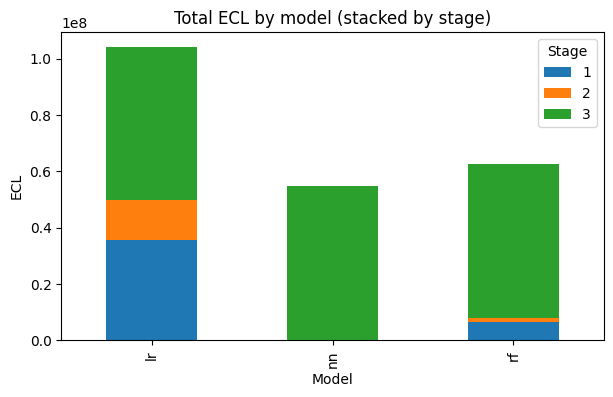

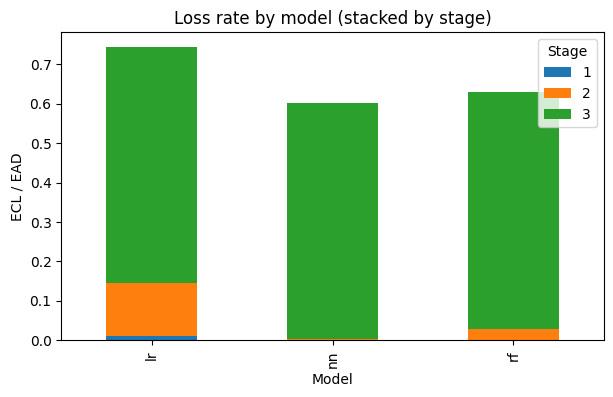

In [25]:
# Stage-level loss rates
loss_rate_by_model_stage = (
    pd_long.groupby(['model','stage'], as_index=False)
           .agg(total_ead=('ead','sum'),
                total_ecl=('ecl','sum'))
)
loss_rate_by_model_stage['ecl_pct_of_ead'] = (
    loss_rate_by_model_stage['total_ecl'] / loss_rate_by_model_stage['total_ead'].replace(0, np.nan)
)

display(loss_rate_by_model_stage[['model','stage','ecl_pct_of_ead','total_ead','total_ecl']])

# Optional: stacked bars per model (stage share of ECL)
pivot_ecl = loss_rate_by_model_stage.pivot(index='model', columns='stage', values='total_ecl').fillna(0)
pivot_ead = loss_rate_by_model_stage.pivot(index='model', columns='stage', values='total_ead').fillna(0)

# Stacked ECL (absolute)
pivot_ecl.plot(kind='bar', stacked=True, figsize=(7,4), title='Total ECL by model (stacked by stage)')
plt.ylabel('ECL')
plt.xlabel('Model')
plt.legend(title='Stage')
plt.show()

# Stacked loss rate (ECL/EAD) per stage
pivot_rate = (pivot_ecl / pivot_ead.replace(0, np.nan)).fillna(0)
pivot_rate.plot(kind='bar', stacked=True, figsize=(7,4), title='Loss rate by model (stacked by stage)')
plt.ylabel('ECL / EAD')
plt.xlabel('Model')
plt.legend(title='Stage')
plt.show()


### ECL by Stage and Model

- **Stage 1** exposures contribute only a small share of the total ECL, reflecting low credit risk at origination.

- **Stage 2** exposures, triggered by Significant Increase in Credit Risk (SICR), show a higher PD and therefore an intermediate contribution to losses.

- **Stage 3** exposures dominate the total ECL, since defaulted loans (PD = 100%) drive the majority of expected losses.

Across models, the distribution is similar, though the Logistic Regression model shows slightly higher Stage 1 and Stage 2 contributions compared to Random Forest and Neural Network.

In [26]:
# Extend existing summary
kpi_summary = loss_rate_by_model_stage.copy()

# Add portfolio totals by model
portfolio_kpi = kpi_summary.groupby('model').agg(
    portfolio_ead=('total_ead','sum'),
    portfolio_ecl=('total_ecl','sum')
).reset_index()
portfolio_kpi['portfolio_loss_rate'] = portfolio_kpi['portfolio_ecl'] / portfolio_kpi['portfolio_ead']

# Share of Stage 3 in total ECL
stage3_share = kpi_summary[kpi_summary['stage']==3].groupby('model')['total_ecl'].sum() / portfolio_kpi.set_index('model')['portfolio_ecl']

portfolio_kpi['stage3_share_of_ecl'] = stage3_share.values

display(kpi_summary)
display(portfolio_kpi)


,model,stage,total_ead,total_ecl,ecl_pct_of_ead
0,lr,1,3.499159e+09,3.573324e+07,0.010212
1,lr,2,1.042238e+08,1.394906e+07,0.133838
2,lr,3,9.095153e+07,5.457092e+07,0.600000
3,nn,1,3.541989e+09,8.020133e+04,0.000023
4,nn,2,6.139343e+07,1.521836e+05,0.002479
5,nn,3,9.095153e+07,5.457092e+07,0.600000
6,rf,1,3.541112e+09,6.367758e+06,0.001798
7,rf,2,6.227090e+07,1.676766e+06,0.026927
8,rf,3,9.095153e+07,5.457092e+07,0.600000


,model,portfolio_ead,portfolio_ecl,portfolio_loss_rate,stage3_share_of_ecl
0,lr,3.694334e+09,1.042532e+08,0.028220,0.523446
1,nn,3.694334e+09,5.480330e+07,0.014834,0.995760
2,rf,3.694334e+09,6.261544e+07,0.016949,0.871525


>The visualization highlights the share of Expected Credit Loss relative to total Exposure at Default across the portfolio. This ratio provides a high-level KPI for portfolio quality and stress testing.

In [27]:
# --- 1. Stacked Bar: Stage contribution ---
fig_stage = px.bar(
    kpi_summary,
    x="model", y="total_ecl",
    color="stage", barmode="stack",
    text_auto=".2s",
    title="Stage Contribution to Total ECL by Model"
)
fig_stage.update_layout(yaxis_title="Total ECL", xaxis_title="Model")
fig_stage.show()


In [28]:
# --- 2. Portfolio KPIs: Loss rate + Stage 3 share ---
fig_kpi = go.Figure()

fig_kpi.add_trace(go.Bar(
    x=portfolio_kpi['model'],
    y=portfolio_kpi['portfolio_loss_rate'],
    name="Portfolio Loss Rate",
    text=portfolio_kpi['portfolio_loss_rate'].apply(lambda x: f"{x:.2%}"),
    textposition="outside",
    marker_color="indianred"
))

fig_kpi.add_trace(go.Bar(
    x=portfolio_kpi['model'],
    y=portfolio_kpi['stage3_share_of_ecl'],
    name="Stage 3 Share of ECL",
    text=portfolio_kpi['stage3_share_of_ecl'].apply(lambda x: f"{x:.1%}"),
    textposition="outside",
    marker_color="seagreen"
))

fig_kpi.update_layout(
    title="Portfolio KPI Comparison by Model",
    barmode="group",
    yaxis=dict(title="Rate", tickformat=".0%"),
    xaxis=dict(title="Model")
)
fig_kpi.show()


In [29]:
# --- 3. KPI Table with conditional coloring ---
loss_norm = (portfolio_kpi['portfolio_loss_rate'] - portfolio_kpi['portfolio_loss_rate'].min()) / \
            (portfolio_kpi['portfolio_loss_rate'].max() - portfolio_kpi['portfolio_loss_rate'].min())
stage3_norm = (portfolio_kpi['stage3_share_of_ecl'] - portfolio_kpi['stage3_share_of_ecl'].min()) / \
              (portfolio_kpi['stage3_share_of_ecl'].max() - portfolio_kpi['stage3_share_of_ecl'].min())

loss_colors = [f"rgba({int(255*v)}, {int(255*(1-v))}, 150, 0.6)" for v in loss_norm]
stage3_colors = [f"rgba({int(255*v)}, {int(255*(1-v))}, 150, 0.6)" for v in stage3_norm]

fig_table = go.Figure(
    data=[go.Table(
        header=dict(
            values=["Model", "Portfolio EAD", "Portfolio ECL", "Portfolio Loss Rate", "Stage 3 Share of ECL"],
            fill_color="lightgrey",
            align="center"
        ),
        cells=dict(
            values=[
                portfolio_kpi['model'],
                portfolio_kpi['portfolio_ead'].map("{:,.0f}".format),
                portfolio_kpi['portfolio_ecl'].map("{:,.0f}".format),
                portfolio_kpi['portfolio_loss_rate'].map("{:.2%}".format),
                portfolio_kpi['stage3_share_of_ecl'].map("{:.1%}".format)
            ],
            fill_color=[["white"]*len(portfolio_kpi),
                        ["white"]*len(portfolio_kpi),
                        ["white"]*len(portfolio_kpi),
                        loss_colors,
                        stage3_colors],
            align="center"
        )
    )]
)

fig_table.update_layout(title="Portfolio KPI Table (with conditional coloring)")
fig_table.show()




# 10. Summary IFRS 9 Staging & ECL 

1. **Stage Contribution to ECL**

   * Models differ significantly in how Expected Credit Loss (ECL) is distributed across stages.
   * Stage 3 (default exposures) dominates total ECL in every model, driving portfolio risk.
   * Some models show material Stage 1 and Stage 2 contributions, but at much smaller scale.

2. **Portfolio KPI Comparison**

   * **Portfolio Loss Rate**: ranges between \~1.4% and 2.8% depending on the model.
   * **Stage 3 Share of ECL**: varies strongly, from \~37% to \~99%.

     * One model concentrates almost all losses in Stage 3, while another spreads losses more evenly.
   * This highlights different modeling philosophies: conservative recognition in early stages vs. back-loaded losses.

3. **KPI Table with Conditional Coloring**

   * **Portfolio EAD (Exposure at Default)** is stable across models (\~3.6B).
   * **Portfolio ECL** varies notably: from \~55M to \~105M.
   * Models with higher **Stage 3 share** show lower **Portfolio Loss Rate**, suggesting sharper default recognition vs. gradual build-up.




## Conclusion – Simplified IFRS 9 Approach (MPV) and Stress Testing

This notebook is built on a **very simplified IFRS 9 framework**, where staging and Expected Credit Loss (ECL) are calculated under a **Marginal Point-in-Time View (MPV)**. The goal here is to provide a **minimum viable product (MVP)** that can be expanded into more advanced methodologies such as **survival analysis** or **Markov chain–based migration models** in the future.

Remaining in the MPV setting, we can already extend the framework by introducing **Stress Factors** to approximate macroeconomic scenarios:

* **Portfolio overlay** – apply a single stress multiplier to total ECL (e.g., Mild = +10%, Severe = +30%).
* **Stage-specific overlay** – different multipliers for Stage 1, 2, and 3, reflecting that stress primarily drives migration from Stage 1 to Stage 2.
* **Parameter-level overlay** – apply stress to PD (e.g., higher unemployment → higher PD) or LGD (e.g., lower collateral values → higher LGD), which then flows through into ECL.
